# How to Combine Samples from Different Parameter Sets

The `povm-toolbox` allows you to run a parameterized quantum circuit and efficiently collect samples for multiple parameter sets -- all through a single Primitive Unified Bloc (PUB). This flexibility is powerful, but it raises an important question: Should you combine the resulting samples, or treat them separately?

> **Note**:
> One parameter set is defined as a set of values that fully fix a parametrized circuit. Check [our tutorial](https://qiskit-community.github.io/povm-toolbox/tutorials/povm_sampler_pub.html) on `POVMSamplerPUB` objects for more details.

This guide walks you through how to combine or isolate samples depending on your analysis goals -- whether you're working with raw measurement counts, analyzing sample distributions, or estimating expectation values.

As a general guideline, we follow the default behaviors established by the Qiskit SDK:

* Expectation Values: The [Qiskit Estimator](https://docs.quantum.ibm.com/guides/get-started-with-primitives#get-started-with-estimator) computes expectation values **separately** for each individual parameter set.
* Samples and Counts: By default, the [Qiskit Sampler](https://docs.quantum.ibm.com/guides/get-started-with-primitives#get-started-with-sampler), on the other hand, **aggregates** (unions) samples across all parameter sets.

We align with those defaults. However, the `povm-toolbox` always gives you full control -- allowing you to explicitly specify whether to combine or separate data, depending on your needs.

## Define your experiment(s)

Start by defining a parametrized quantum circuit.

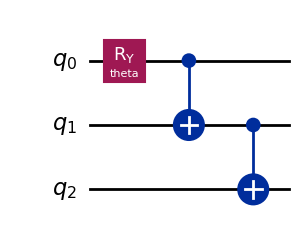

In [1]:
import numpy as np
from qiskit.circuit import Parameter, QuantumCircuit

qc = QuantumCircuit(3)

theta = Parameter("theta")
qc.ry(theta, 0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.draw("mpl", style="iqp")

### Understanding the shape of a PUB

In general, the array of parameter values in a PUB has the shape $(n_1, ..., n_N, p)$, called the _shape of the PUB_, where
- the last dimension corresponds to the _parameter set_, which is always of dimension 1 and whose length, $p$, equals the number of parameters in the circuit;
- the leading dimensions form the _binding array_, where each entry represents a single parameter set of size $p$. The binding array is $N$-dimensional.

> **Note**:
> the binding array may be zero-dimensional resulting in a PUB of shape $(p,)$, which indicates that a single parameter set is provided.

In our current example, the quantum circuit has exactly one parameter, therefore a "parameter set" will simply be a list with one scalar element.

Let’s consider three scenarios:
<ol type="a">
  <li>One parameter set is submitted, as a PUB of shape (1,); therefore, the corresponding binding array is 0-dimensional,</li>
  <li>Two parameter sets are submitted, as a PUB of shape (2,1); therefore, the corresponding binding array is 1-dimensional and of shape (2,), and </li>
  <li>Six parameter sets are submitted, as a PUB of shape (3,2,1); therefore, the corresponding binding array is 2-dimensional and of shape (3,2).</li>
</ol>

> **Note**:
> when the circuit has only one parameter, the last dimension of the PUB can be squeezed. In such a case, this will be automatically detected internally and the missing dimension will be added. 

In [2]:
pv_0 = np.asarray([np.pi / 2])
pub_0 = (qc, pv_0)
print(f"Shape of binding array 0: {pv_0.shape[:-1]}")

pv_1 = np.asarray([[0], [np.pi / 2]])
pub_1 = (qc, pv_1)
print(f"Shape of binding array 1: {pv_1.shape[:-1]}")

pv_2 = np.asarray(
    [
        [[0], [np.pi / 2]],
        [[0.1], [np.pi / 2 + 0.1]],
        [[0.2], [np.pi / 2 + 0.2]],
    ]
)
pub_2 = (qc, pv_2)
print(f"Shape of binding array 2: {pv_2.shape[:-1]}")

Shape of binding array 0: ()
Shape of binding array 1: (2,)
Shape of binding array 2: (3, 2)


We now set up a basic classical shadows POVM and generate the results to be post-processed in the rest of this guide.


In [3]:
from povm_toolbox.library import ClassicalShadows
from povm_toolbox.sampler import POVMSampler
from qiskit.primitives import StatevectorSampler as BaseSampler

povm = ClassicalShadows(3)
povm_sampler = POVMSampler(sampler=BaseSampler())
povm_job = povm_sampler.run([pub_0, pub_1, pub_2], shots=64, povm=povm)
primitive_result = povm_job.result()

## 1) Expectation Values

### Default: compute expectation values separately for each individual parameter sets.

In [4]:
from povm_toolbox.post_processor import POVMPostProcessor
from qiskit.quantum_info import SparsePauliOp

obs = SparsePauliOp("IZI")

for i, povm_pub_result in enumerate(primitive_result):
    post_processor = POVMPostProcessor(povm_pub_result)
    print(f"Expectation values of PUB {i}:")
    evs, stds = post_processor.get_expectation_value(obs)
    print(evs, end="\n\n")

Expectation values of PUB 0:
-0.4687500000000005

Expectation values of PUB 1:
[1.03125  0.140625]

Expectation values of PUB 2:
[[ 0.984375  0.046875]
 [ 0.84375   0.46875 ]
 [ 1.171875 -0.140625]]



### Combine the counts via the argument `combine_counts` when initializing the `POVMPostProcessor` object. 

In [5]:
for i, povm_pub_result in enumerate(primitive_result):
    post_processor = POVMPostProcessor(povm_pub_result, combine_counts=True)
    print(f"Expectation values of PUB {i}:")
    evs, stds = post_processor.get_expectation_value(obs)
    print(evs, end="\n\n")

Expectation values of PUB 0:
-0.4687500000000005

Expectation values of PUB 1:
0.5859374999999994

Expectation values of PUB 2:
0.5624999999999996



## 2) Counts and Outcomes

### Default: outcomes are unioned together across all parameter sets

Calling the `POVMPubResult.get_counts` method will return, by default, a single counter object where samples from all parameter sets were unioned together.

In [6]:
for i, povm_pub_result in enumerate(primitive_result):
    print(f"Counts of PUB {i}:")
    counts = povm_pub_result.get_counts()  # equivalent to `.get_counts(loc=None)`
    print(counts, end="\n\n")

Counts of PUB 0:
Counter({(4, 1, 1): 3, (1, 2, 4): 3, (0, 0, 0): 2, (5, 3, 0): 2, (2, 1, 5): 2, (3, 3, 0): 2, (3, 1, 5): 2, (2, 0, 2): 2, (5, 1, 3): 2, (1, 1, 1): 2, (2, 1, 1): 2, (0, 2, 2): 2, (0, 3, 2): 1, (0, 2, 0): 1, (2, 3, 3): 1, (4, 4, 3): 1, (5, 5, 3): 1, (4, 3, 0): 1, (5, 2, 0): 1, (4, 2, 5): 1, (2, 5, 2): 1, (1, 1, 5): 1, (5, 1, 5): 1, (0, 2, 3): 1, (2, 1, 3): 1, (0, 3, 3): 1, (4, 0, 0): 1, (3, 4, 0): 1, (5, 4, 2): 1, (1, 2, 1): 1, (5, 2, 3): 1, (0, 5, 0): 1, (5, 2, 2): 1, (0, 3, 4): 1, (3, 4, 1): 1, (1, 1, 4): 1, (3, 0, 5): 1, (1, 3, 2): 1, (0, 0, 5): 1, (3, 1, 3): 1, (2, 3, 1): 1, (0, 0, 2): 1, (4, 3, 4): 1, (2, 1, 4): 1, (5, 0, 5): 1, (5, 2, 4): 1, (5, 2, 1): 1, (2, 0, 0): 1, (3, 5, 0): 1, (4, 1, 2): 1})

Counts of PUB 1:
Counter({(0, 0, 0): 4, (0, 3, 5): 4, (0, 0, 4): 4, (2, 0, 0): 3, (3, 4, 2): 3, (3, 0, 4): 3, (0, 5, 2): 3, (3, 0, 0): 3, (5, 3, 2): 3, (3, 2, 3): 2, (2, 3, 5): 2, (0, 0, 2): 2, (2, 3, 4): 2, (5, 5, 2): 2, (5, 4, 0): 2, (4, 4, 5): 2, (2, 2, 2): 2, (5, 2, 2

Similarly, when calling the `POVMPubResult.get_samples` method, a single flatten list of samples is returned.

In [7]:
for i, povm_pub_result in enumerate(primitive_result):
    print(f"Samples of PUB {i}:")
    samples = povm_pub_result.get_samples()  # equivalent to `.get_counts(loc=None)`
    print(samples, end="\n\n")

Samples of PUB 0:
[(0, 3, 2), (0, 0, 0), (0, 2, 0), (2, 3, 3), (0, 0, 0), (4, 1, 1), (4, 4, 3), (5, 5, 3), (5, 3, 0), (1, 2, 4), (2, 1, 5), (4, 3, 0), (5, 2, 0), (3, 3, 0), (4, 1, 1), (3, 1, 5), (2, 0, 2), (4, 2, 5), (2, 5, 2), (1, 1, 5), (5, 1, 5), (0, 2, 3), (1, 2, 4), (3, 3, 0), (2, 1, 3), (1, 2, 4), (0, 3, 3), (4, 0, 0), (5, 1, 3), (4, 1, 1), (3, 4, 0), (5, 4, 2), (1, 2, 1), (1, 1, 1), (5, 2, 3), (2, 1, 5), (0, 5, 0), (5, 2, 2), (0, 3, 4), (1, 1, 1), (2, 1, 1), (0, 2, 2), (2, 1, 1), (3, 4, 1), (1, 1, 4), (5, 1, 3), (3, 0, 5), (1, 3, 2), (0, 0, 5), (3, 1, 5), (3, 1, 3), (2, 3, 1), (0, 0, 2), (4, 3, 4), (2, 1, 4), (5, 0, 5), (5, 2, 4), (5, 2, 1), (0, 2, 2), (2, 0, 0), (2, 0, 2), (5, 3, 0), (3, 5, 0), (4, 1, 2)]

Samples of PUB 1:
[(0, 4, 3), (2, 0, 0), (0, 0, 0), (3, 2, 3), (0, 3, 5), (2, 4, 5), (0, 3, 5), (2, 3, 5), (0, 0, 2), (2, 3, 4), (0, 2, 3), (3, 4, 3), (0, 3, 0), (0, 0, 4), (3, 4, 2), (3, 0, 4), (5, 5, 2), (5, 4, 0), (5, 0, 5), (4, 4, 2), (0, 2, 2), (4, 0, 5), (4, 5, 5), (0, 

### Keep the counts separated

Instead of aggregating all the counts together, one can request all the counts separately via the argument `loc=...` of the `POVMPubResult.get_counts` method.
It will return an array of counter objects, whose shape will match the binding array provided in the corresponding PUB.

In [8]:
for i, povm_pub_result in enumerate(primitive_result):
    print(f"Counts of PUB {i}:")
    counts = povm_pub_result.get_counts(loc=...)
    print(counts)
    print(f"Shape: {counts.shape}", end="\n\n")

Counts of PUB 0:
[Counter({(4, 1, 1): 3, (1, 2, 4): 3, (0, 0, 0): 2, (5, 3, 0): 2, (2, 1, 5): 2, (3, 3, 0): 2, (3, 1, 5): 2, (2, 0, 2): 2, (5, 1, 3): 2, (1, 1, 1): 2, (2, 1, 1): 2, (0, 2, 2): 2, (0, 3, 2): 1, (0, 2, 0): 1, (2, 3, 3): 1, (4, 4, 3): 1, (5, 5, 3): 1, (4, 3, 0): 1, (5, 2, 0): 1, (4, 2, 5): 1, (2, 5, 2): 1, (1, 1, 5): 1, (5, 1, 5): 1, (0, 2, 3): 1, (2, 1, 3): 1, (0, 3, 3): 1, (4, 0, 0): 1, (3, 4, 0): 1, (5, 4, 2): 1, (1, 2, 1): 1, (5, 2, 3): 1, (0, 5, 0): 1, (5, 2, 2): 1, (0, 3, 4): 1, (3, 4, 1): 1, (1, 1, 4): 1, (3, 0, 5): 1, (1, 3, 2): 1, (0, 0, 5): 1, (3, 1, 3): 1, (2, 3, 1): 1, (0, 0, 2): 1, (4, 3, 4): 1, (2, 1, 4): 1, (5, 0, 5): 1, (5, 2, 4): 1, (5, 2, 1): 1, (2, 0, 0): 1, (3, 5, 0): 1, (4, 1, 2): 1})]
Shape: (1,)

Counts of PUB 1:
[Counter({(0, 0, 0): 4, (2, 0, 0): 3, (0, 3, 5): 2, (0, 0, 4): 2, (3, 0, 4): 2, (5, 5, 2): 2, (5, 4, 0): 2, (3, 0, 0): 2, (2, 2, 2): 2, (5, 3, 2): 2, (5, 2, 2): 2, (4, 4, 3): 2, (4, 3, 2): 2, (0, 4, 3): 1, (3, 2, 3): 1, (2, 4, 5): 1, (2, 3, 

The same applies for the `POVMPubResult.get_samples` method:

In [9]:
for i, povm_pub_result in enumerate(primitive_result):
    print(f"Samples of PUB {i}:")
    samples = povm_pub_result.get_samples(loc=...)
    print(samples)
    print(f"Shape: {samples.shape}", end="\n\n")

Samples of PUB 0:
[list([(0, 3, 2), (0, 0, 0), (0, 2, 0), (2, 3, 3), (0, 0, 0), (4, 1, 1), (4, 4, 3), (5, 5, 3), (5, 3, 0), (1, 2, 4), (2, 1, 5), (4, 3, 0), (5, 2, 0), (3, 3, 0), (4, 1, 1), (3, 1, 5), (2, 0, 2), (4, 2, 5), (2, 5, 2), (1, 1, 5), (5, 1, 5), (0, 2, 3), (1, 2, 4), (3, 3, 0), (2, 1, 3), (1, 2, 4), (0, 3, 3), (4, 0, 0), (5, 1, 3), (4, 1, 1), (3, 4, 0), (5, 4, 2), (1, 2, 1), (1, 1, 1), (5, 2, 3), (2, 1, 5), (0, 5, 0), (5, 2, 2), (0, 3, 4), (1, 1, 1), (2, 1, 1), (0, 2, 2), (2, 1, 1), (3, 4, 1), (1, 1, 4), (5, 1, 3), (3, 0, 5), (1, 3, 2), (0, 0, 5), (3, 1, 5), (3, 1, 3), (2, 3, 1), (0, 0, 2), (4, 3, 4), (2, 1, 4), (5, 0, 5), (5, 2, 4), (5, 2, 1), (0, 2, 2), (2, 0, 0), (2, 0, 2), (5, 3, 0), (3, 5, 0), (4, 1, 2)])]
Shape: (1,)

Samples of PUB 1:
[list([(0, 4, 3), (2, 0, 0), (0, 0, 0), (3, 2, 3), (0, 3, 5), (2, 4, 5), (0, 3, 5), (2, 3, 5), (0, 0, 2), (2, 3, 4), (0, 2, 3), (3, 4, 3), (0, 3, 0), (0, 0, 4), (3, 4, 2), (3, 0, 4), (5, 5, 2), (5, 4, 0), (5, 0, 5), (4, 4, 2), (0, 2, 2), 

### Advanced : specific `loc``

One can also request the counts for a specific parameter set of the binding array via the argument `loc`, which is a multi-index given as a tuple of integers.

In [10]:
counts = primitive_result[0].get_counts(loc=tuple())  # shortcut : `loc=None` (default)
print(f"Counter of PUB 0 at `loc=(,)`: {counts}")

counts = primitive_result[1].get_counts(
    loc=(0,)
)  # shortcut : `loc=0` transformed internally to the tuple (0,)
print(f"Counter of PUB 1 at `loc=(0,)`: {counts}")

counts = primitive_result[2].get_counts(loc=(2, 0))
print(f"Counter of PUB 2 at `loc=(2,0)`: {counts}")

Counter of PUB 0 at `loc=(,)`: Counter({(4, 1, 1): 3, (1, 2, 4): 3, (0, 0, 0): 2, (5, 3, 0): 2, (2, 1, 5): 2, (3, 3, 0): 2, (3, 1, 5): 2, (2, 0, 2): 2, (5, 1, 3): 2, (1, 1, 1): 2, (2, 1, 1): 2, (0, 2, 2): 2, (0, 3, 2): 1, (0, 2, 0): 1, (2, 3, 3): 1, (4, 4, 3): 1, (5, 5, 3): 1, (4, 3, 0): 1, (5, 2, 0): 1, (4, 2, 5): 1, (2, 5, 2): 1, (1, 1, 5): 1, (5, 1, 5): 1, (0, 2, 3): 1, (2, 1, 3): 1, (0, 3, 3): 1, (4, 0, 0): 1, (3, 4, 0): 1, (5, 4, 2): 1, (1, 2, 1): 1, (5, 2, 3): 1, (0, 5, 0): 1, (5, 2, 2): 1, (0, 3, 4): 1, (3, 4, 1): 1, (1, 1, 4): 1, (3, 0, 5): 1, (1, 3, 2): 1, (0, 0, 5): 1, (3, 1, 3): 1, (2, 3, 1): 1, (0, 0, 2): 1, (4, 3, 4): 1, (2, 1, 4): 1, (5, 0, 5): 1, (5, 2, 4): 1, (5, 2, 1): 1, (2, 0, 0): 1, (3, 5, 0): 1, (4, 1, 2): 1})
Counter of PUB 1 at `loc=(0,)`: Counter({(0, 0, 0): 4, (2, 0, 0): 3, (0, 3, 5): 2, (0, 0, 4): 2, (3, 0, 4): 2, (5, 5, 2): 2, (5, 4, 0): 2, (3, 0, 0): 2, (2, 2, 2): 2, (5, 3, 2): 2, (5, 2, 2): 2, (4, 4, 3): 2, (4, 3, 2): 2, (0, 4, 3): 1, (3, 2, 3): 1, (2, 4, 5